In [ ]:
# mount drive to access files and directories
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# install necessary libraries to patchify images
!pip install patchify
!pip install import-ipynb
%cd "/content/gdrive/MyDrive/CS230_VIT"

In [ ]:
# import all necessary libraries
import os
import import_ipynb
import pickle
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import sys
sys.path.append('/content/gdrive/MyDrive/CS230_VIT/')
from patchify import patchify
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from itertools import cycle
from tensorflow import keras
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

In [ ]:
# load ViT function from vit_cs230 python file
from vit_cs230 import ViT

importing Jupyter notebook from vit.ipynb


In [ ]:
# define hyperparameters (can tune all parameters marked "EDIT")
""" Hyperparameters """
hp = {}
hp["image_size"] = 200
hp["num_channels"] = 3
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 32     # EDIT
hp["lr"] = 1e-4
hp["num_epochs"] = 500    # EDIT
hp["num_classes"] = 20
hp["class_names"] = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                     '11', '12', '13', '14', '15', '16', '17', '18', '19']

hp["num_layers"] = 12     # EDIT
hp["hidden_dim"] = 768    # EDIT
hp["mlp_dim"] = 3072
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1  # EDIT

In [ ]:
# define functions to patchify images and load them and labels into dataset
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
# we chose a 60/20/20 split for this VIT model
def load_data(path, split=0.2): 
    images = shuffle(glob(os.path.join(path, "*", "*")))
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    return train_x, valid_x, test_x


def process_image_label(path):
    # read images
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image/255.0

    # patchify
    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])
    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    # get label from name of folder containing images
    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx

def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])
    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])
    return patches, labels

def tf_dataset(images, batch=32): # ensure compatibility with earlier declaration
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds

In [ ]:
if __name__ == "__main__":
    # set the seeding
    np.random.seed(42)
    tf.random.set_seed(42)

    # declare the paths
    dataset_path = "/content/gdrive/MyDrive/CS230_VIT/mured_dataset/"
    model_path = os.path.join("files", "model.h5")

    # load dataset
    train_x, valid_x, test_x = load_data(dataset_path)
    test_ds = tf_dataset(test_x, batch=hp["batch_size"])

    # define model
    model = ViT(hp)
    model.load_weights(model_path)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(hp["lr"]),
        metrics=["acc"]
    )

    model.evaluate(test_ds)

Train: 6033 - Valid: 2010 - Test: 2010
63/63 [==============================] - 1185s 19s/step - loss: 0.5683 - acc: 0.8622


In [ ]:
# extract y_test from dataset for evaluation
data = list(test_ds)

first_batches = []
for i in range(np.shape(data)[0] - 1):
  first_batches.append(data[i][1])
last_batch = data[62][1]
last_batch = np.array(last_batch, dtype="float")

y_test = []
for i in range(np.shape(first_batches)[0]): # 62
  for j in range(np.shape(first_batches)[1]):
    y_test.append(first_batches[i][j])
    
y_test = np.array(y_test, dtype="float")
y_test = np.append(y_test, last_batch, axis=0)

In [ ]:
# get y_pred from model
y_pred = model.predict(test_ds)

63/63 [==============================] - 13s 176ms/step


In [ ]:
# convert one-hot embeddings to int for y_test and y_pred
y_test_toInt = []
for i in range(np.shape(y_test)[0]):
  y_test_toInt.append(np.argmax(y_test[i]))

y_pred_toInt = []
for i in range(np.shape(y_pred)[0]):
  y_pred_toInt.append(np.argmax(y_pred[i]))

In [ ]:
# save y_test and y_pred to pickle file
pickle.dump( y_test_toInt, open( "/content/gdrive/MyDrive/CS230_VIT/y_test_int_VIT.p", "wb" ) )
pickle.dump( y_pred_toInt, open( "/content/gdrive/MyDrive/CS230_VIT/y_pred_int_VIT.p", "wb" ) )

In [ ]:
# load y_test and y_pred from pickle file
y_test = pickle.load( open( "/content/gdrive/MyDrive/CS230_VIT/y_test_int_VIT.p", "rb" ) )
y_pred = pickle.load( open( "/content/gdrive/MyDrive/CS230_VIT/y_pred_int_VIT.p", "rb" ) )

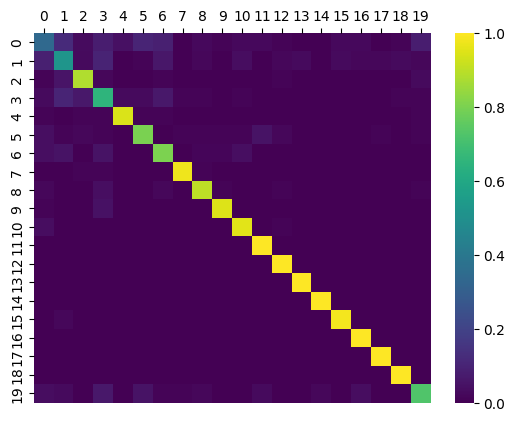

In [ ]:
# confusion matrix
categories = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
cf_matrix = confusion_matrix(y_true, y_pred, labels = categories)
row_sums = cf_matrix.sum(axis=1)
df_norm_col = cf_matrix / row_sums[:, np.newaxis]
ax = sns.heatmap(df_norm_col, cmap='viridis', annot=False)
ax.xaxis.tick_top()

In [ ]:
# convert y_test and y_pred to one-hot
y_onehot_test = keras.utils.to_categorical(y_test, 20)
y_onehot_pred = keras.utils.to_categorical(y_pred, 20)

In [ ]:
# calculate area under the curve of ROC
n_classes = 20
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    yot = y_onehot_test[:][i]
    yop = y_onehot_pred[:][i]
    fpr[i], tpr[i], _ = roc_curve(yot, yop)
    roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc

{0: 1.0,
 1: 0.4736842105263158,
 2: 1.0,
 3: 0.4736842105263158,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 0.4736842105263158,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0}

In [ ]:
# accuracy from average
sum(roc_auc.values()) / n_classes

0.9210526315789472

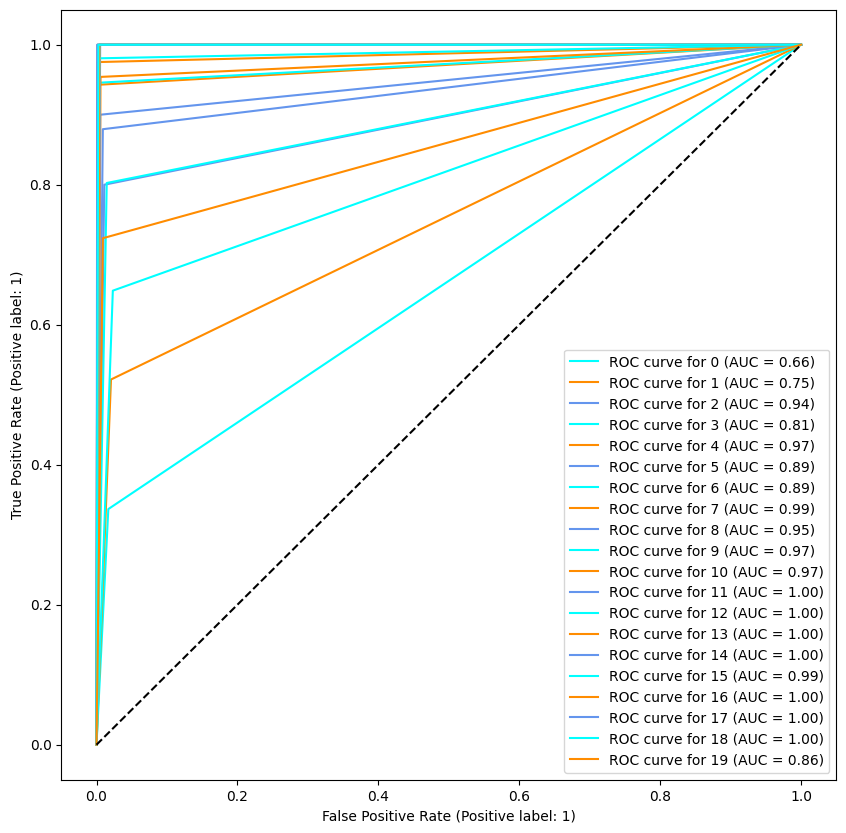

In [ ]:
# ROC curve
fig, ax = plt.subplots(figsize=(10, 10))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_onehot_pred[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")